# Numerical simulation for upper bound on dynamic blocksize expansion

Mitchell / Isthmus - Sept 2018, updated Jan 2019

## Abstract:

The current bound on expansion of the Monero block(/chain) is that each block cannot be larger than the median size of the previous 100 blocks. Given the 2-minute block time, this means that the protocol has a few-hour memory, which performs well for most use cases and conditions. 

However, it is prudent to consider edge cases as well, and the current absence of medium or long-term memory comes with a significant risk. Under the current protocol, sustained high transaction volume (due to rapid adoption or a well-funded spammer) induces a rapid exponential increase in resource requirements (disk space, bandwidth, etc) that would exceed the capacities of the extant Monero infrastructure on the scale of hours

This notebook quantifies the scale of damage in the worst-case-scenarios that could arise from overwhelming adoption or a deliberate spam attack. The current system (short-term memory only) is compared to two proposed mitigation strategies: a two point long/short-term memory, and an additive limit.

## Background Reading:

-  Jolly Mort's [Monero Dynamic Block Size and Dynamic Minimum Fee](https://github.com/JollyMort/monero-research/blob/master/Monero%20Dynamic%20Block%20Size%20and%20Dynamic%20Minimum%20Fee/Monero%20Dynamic%20Block%20Size%20and%20Dynamic%20Minimum%20Fee%20-%20DRAFT.md)
-  ArticMine's [BitcoinTalk discussion](https://bitcointalk.org/index.php?topic=753252.msg13591241#msg13591241) about oversize block attacks.

The topic of blockchain bloat has been discussed in many communities for many years. This notebook is not the first mention of the idea, it simply seeks to quantify the rate and scale of increasing resource demand, and test strategies proposed to protect the Monero cryptocurrency.

## Risk:

The block size can be maximized by any set of transactions in the memory pool whose:
-  Net fee > coinbase
-  Net size ~ 2*median(last 100 blocks)

*Note: depending on assumptions about miner software and transaction selection methodology, a net fee of 4x coinbase may be necessary to induce a maximum-size block.*

We'll consider "Icarus adoption" to be any scenario (whether benignly or maliciously induced) that causes a flood of transactions that increases resource requirements beyond the capacity of the Monero infrastructure (e.g. exceeding the disk space or bandwidth of most nodes and miners).

## Result:

Under the current system, the *block size* doubles every 51 blocks (i.e. doubling 14 times each day) indefinitely. The *blockchain size* doubles in less than a day and grows catastrophically large shortly thereafter.

## Conclusions:

Most cryptoeconomic schemes include fee/reward mechanisms designed to discourage undesired behavior from financially-rational parties under economic equilibrium conditions. However all protocols must include secondary fail-safe mechanisms to protect the network against literally "overwhelming" adoption and/or adversaries whose external agendas override economic motivations.

## Simulations

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Set parameters

General state information about simulation and cost estimation

In [2]:
# Simulation parameters
initial_blocksize = 600 # kB # penalty-free up to 300 kB
num_blocks_simulate = 36*30+1 # just over 36 hours
current_blockchain_size_GB = 65 # GB
circulating_supply = 16697487 # XMR

# Economic parameters
cost_of_1_XMR = 50 # EUR
current_reward = 2 # XMR

Set the timescale and growth bound for two-point short/long term memory.

In [3]:
# For 2-point short/long-term memory
short_term_max_growth = 1.4 # multiplier
short_term_memory = 100 # blocks
long_term_max_growth = 50 # multiplier
long_term_memory = 100000 # blocks

# Make a note of the legend for figures
LSTM_legend = '2-point memory: min['+str(short_term_max_growth)+'*M('+str(short_term_memory)+'), '+str(long_term_max_growth)+'*M('+str(long_term_memory)+')'+']'

Set the number of (exponentially-distributed) time scales to be used in the span multi-timescale memory model. For example, `index_offset = 7` and `index_set_size = 6` checks the growth in the last $2^7$ blocks, last $2^8$ blocks, ..., last $2^{13}$ blocks.

In [4]:
# For span memory (multi-timescale)
index_offset = 7
index_set_size = 6

Set the size for temporary fixed cap (not optimal solution)

In [5]:
fixed_cap_kB = 5000

Let's also model additive growth since this results in a linear expansion instead of exponential blowup. Set the maximum expansion per block.

In [6]:
additive_allowance_kB = 300

### Initialize simulation

In [7]:
# Initialize with lowball estimate that last 100 blocks were 100 kB in size
pre_length = max(100, long_term_memory, 2**(7+index_set_size))

height_vector = list(range(-pre_length,num_blocks_simulate)) 
block_sizes = (pre_length+num_blocks_simulate)*[initial_blocksize] # For regular model
block_sizes_LSTM = (pre_length+num_blocks_simulate)*[initial_blocksize] # For 2-point memory
block_sizes_span = (pre_length+num_blocks_simulate)*[initial_blocksize] # For span memory
block_sizes_cap = (pre_length+num_blocks_simulate)*[initial_blocksize] # For temporary cap
block_sizes_add = (pre_length+num_blocks_simulate)*[initial_blocksize] # For additive approach
block_sizes_ETH = (pre_length+num_blocks_simulate)*[initial_blocksize] # For additive approach

### Run simulation
Simulation loops over heights, and models three possible boundings:
-  Short term memory only (current implementation)
-  Two-point short/long-term memory
-  Span memory, a generalization to more than 2 points/timescales

In [8]:
LSTM_long_cap_triggered = (pre_length+num_blocks_simulate)*[0]

for attack_block_num in range(pre_length, pre_length + num_blocks_simulate):
        
    # Model short-term memory (current method)
    last_blocks = block_sizes[(attack_block_num-100):attack_block_num]
    median_prev = np.median(last_blocks)
    next_size = 2*median_prev
    block_sizes[attack_block_num] = next_size
    
    # Model ETH
    last_block_ETH = block_sizes_ETH[attack_block_num-1]
    next_size_ETH = ((1+1/1024)**(120/15))*last_block_ETH
    block_sizes_ETH[attack_block_num] = next_size_ETH
    
    # Model two-point short/long-term memory   
    last_blocks_short = block_sizes_LSTM[(attack_block_num-short_term_memory):attack_block_num]
    median_prev_short = np.median(last_blocks_short)
    next_size_short = short_term_max_growth*median_prev_short
    last_blocks_long = block_sizes_LSTM[(attack_block_num-long_term_memory):attack_block_num]
    median_prev_long = np.median(last_blocks_long)
    next_size_long = long_term_max_growth*median_prev_long
    next_size_LSTM = min(next_size_short, next_size_long)
    if next_size_long < next_size_short:
        LSTM_long_cap_triggered[attack_block_num] = 1
        # ^ Mark when we switch from short-limited growth to long-limited
    block_sizes_LSTM[attack_block_num] = next_size_LSTM  
    
    # Model span multi-timescale memory
    size_list = index_set_size*[np.inf]
    c = 0
    for k in range(index_offset, index_offset + index_set_size):
        this_memory_len = 2**k
        last_blocks_span = block_sizes_span[(attack_block_num-this_memory_len):attack_block_num]
        median_prev_span = np.median(last_blocks_span) 
        this_B = (2+c/index_set_size)*median_prev_span
        size_list[c] = this_B
        c = c + 1
    block_sizes_span[attack_block_num] = min(size_list)
        
    # Model cap
    last_blocks_cap = block_sizes_cap[(attack_block_num-100):attack_block_num]
    median_prev_cap = np.median(last_blocks_cap)
    next_size_cap = min(2*median_prev_cap, fixed_cap_kB)
    block_sizes_cap[attack_block_num] = next_size_cap
    
    # Model additive
    last_blocks_add = block_sizes_add[(attack_block_num-100):attack_block_num]
    median_prev_add = np.median(last_blocks_add)
    next_size_add = median_prev_add + additive_allowance_kB
    block_sizes_add[attack_block_num] = next_size_add
        


## Plot results

### Block size increase

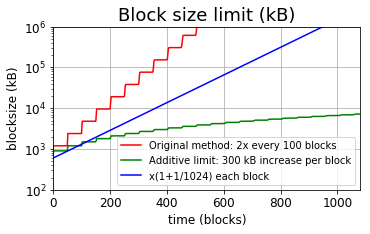

In [9]:
fig = plt.figure(figsize=(5.5,3))
ax = fig.add_subplot(111)
plt.plot(height_vector, block_sizes,'r', label='Original method: 2x every 100 blocks')
plt.plot(height_vector, block_sizes_add,'g', label = 'Additive limit: ' + str(additive_allowance_kB) + ' kB increase per block')
#plt.plot(height_vector, block_sizes_LSTM,'c', label = LSTM_legend)
plt.plot(height_vector, block_sizes_ETH,'b', label = 'x(1+1/1024) each block')
plt.set_yscale = 'log'
plt.xlabel('time (blocks)', fontsize='12')
plt.ylabel('blocksize (kB)',  fontsize='12')
plt.title('Block size limit (kB)',  fontsize='18')
plt.grid(True)
ax.legend(loc='best', fontsize='10')
ax.set_xlim(0, num_blocks_simulate)
ax.set_yscale('log')
#ax.set_ylim(1,block_sizes[num_blocks_simulate])
ax.set_ylim(1e2,1e6)
plt.xticks(size = 12)
plt.yticks(size = 12)
#plt.text(200, 2, 'Isthmus', fontsize=12)
plt.show()

### Blockchain size bloat

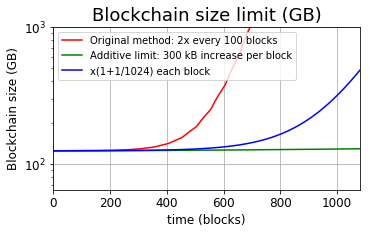

In [10]:
fig = plt.figure(figsize=(5.5,3))
ax = fig.add_subplot(111)
plt.plot(height_vector, current_blockchain_size_GB + np.cumsum(block_sizes)/1e6,'r', label='Original method: 2x every 100 blocks')
plt.plot(height_vector, current_blockchain_size_GB + np.cumsum(block_sizes_add)/1e6,'g',  label = 'Additive limit: ' + str(additive_allowance_kB) + ' kB increase per block')
plt.plot(height_vector, current_blockchain_size_GB + np.cumsum(block_sizes_ETH)/1e6,'b',  label = 'x(1+1/1024) each block')
# plt.plot(height_vector, current_blockchain_size_GB + np.cumsum(block_sizes_LSTM)/1e6,'c', label = LSTM_legend)
plt.set_yscale = 'log'
plt.xlabel('time (blocks)', fontsize='12')
plt.ylabel('Blockchain size (GB)',  fontsize='12')
plt.title('Blockchain size limit (GB)',  fontsize='18')
plt.grid(True)
ax.legend(loc='best', fontsize='10')
ax.set_xlim(0, num_blocks_simulate)
ax.set_yscale('log')
ax.set_ylim([65,1e3])
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()


## Cost analysis (GB bloat per €)

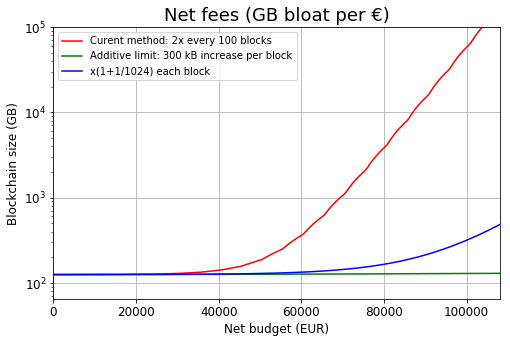

In [11]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
cost_vector = [h*(cost_of_1_XMR*current_reward) for h in height_vector]
cum_curr_GB =  current_blockchain_size_GB + np.cumsum(block_sizes)/1e6;
plt.plot(cost_vector, current_blockchain_size_GB + np.cumsum(block_sizes)/1e6,'r', label='Curent method: 2x every 100 blocks')
plt.plot(cost_vector, current_blockchain_size_GB + np.cumsum(block_sizes_add)/1e6, 'g', label = 'Additive limit: ' + str(additive_allowance_kB) + ' kB increase per block')
plt.plot(cost_vector, current_blockchain_size_GB + np.cumsum(block_sizes_ETH)/1e6,'b', label = 'x(1+1/1024) each block')

plt.xlabel('Net budget (EUR)', fontsize='12')
plt.ylabel('Blockchain size (GB)',  fontsize='12')
plt.set_yscale = 'log'
plt.title('Net fees (GB bloat per €)',  fontsize='18')
plt.grid(True)
ax.legend(loc='best', fontsize='10')
ax.set_xlim(1, max(cost_vector))
ax.set_ylim(65,1e5)
ax.set_yscale('log')
plt.xticks(size = 12)
plt.yticks(size = 12)
#plt.text(20000, 100, 'Isthmus', fontsize=12)
plt.show()

### Check out some key times, sizes, costs
This is a bunch of verbose text output, if desired. Commented out

In [12]:
skip_me = 0

if skip_me < 1:
#    time_dict = {30: '1st hour', 9*30:'9th hour', 18*30:'18th hour', 24*30:'1st day', 36*30:'36th hour', 2*24*30:'2nd day', 7*24*30:'1st week'}
    time_dict = {6*30: '6', 12*30:'12', 18*30:'18', 24*30:'24', 36*30:'36'}

    for time_in_blocks in time_dict:
        print('\n' + 25*'*')
        print('At the end of the ' + time_dict[time_in_blocks] + 'th hour:')
        print('-')
        print('# Current algorithm')
        print('Blocksize = ' + str(block_sizes[pre_length + time_in_blocks]) + ' kB')
        print('>>> Blockchain size = ' + str(current_blockchain_size_GB + sum(block_sizes[pre_length:(pre_length + time_in_blocks)])/1e6) + ' GB')
        print('-')
        
        print('# Two-point short/long-term algorithm')
        print('Blocksize = ' + str(block_sizes_LSTM[pre_length + time_in_blocks]) + ' kB')
        print('Blockchain size = ' + str(current_blockchain_size_GB + sum(block_sizes_LSTM[pre_length:(pre_length + time_in_blocks)])/1e6) + ' GB')
        print('-')
        print('# Two-point short/long-term algorithm')
        print('Blocksize = ' + str(block_sizes_span[pre_length + time_in_blocks]) + ' kB')
        print('Blockchain size = ' + str(current_blockchain_size_GB + sum(block_sizes_span[pre_length:(pre_length + time_in_blocks)])/1e6) + ' GB')
        print('-')        
        
        print('# Additive cap')
        print(str(additive_allowance_kB) + ' kB additive allowance')
        print('Blocksize = ' + str(block_sizes_add[pre_length + time_in_blocks]) + ' kB')
        print('Blockchain size = ' + str(current_blockchain_size_GB + sum(block_sizes_add[pre_length:(pre_length + time_in_blocks)])/1e6) + ' GB')
        print('-')
        
        # print('# Hard cap')
        # print(str(fixed_cap_kB) + ' kB hard cap')
        # print('Blocksize = ' + str(block_sizes_cap[pre_length + time_in_blocks]) + ' kB')
        # print('Blockchain size = ' + str(current_blockchain_size_GB + sum(block_sizes_cap[pre_length:(pre_length + time_in_blocks)])/1e6) + ' GB')
        # print('-')
         
        print('Net fees ~ ' + str(current_reward*time_in_blocks) + ' XMR')
        print('Net fees ~ ' + str(cost_of_1_XMR*current_reward*time_in_blocks) + ' EUR')
        print('stake ~ ' + str(round(current_reward*time_in_blocks/circulating_supply,5)*100) + '%')



*************************
At the end of the 6th hour:
-
# Current algorithm
Blocksize = 9600.0 kB
>>> Blockchain size = 65.6978 GB
-
# Two-point short/long-term algorithm
Blocksize = 2304.9599999999996 kB
Blockchain size = 65.25064256 GB
-
# Two-point short/long-term algorithm
Blocksize = 1400.0 kB
Blockchain size = 65.2328 GB
-
# Additive cap
300 kB additive allowance
Blocksize = 1800.0 kB
Blockchain size = 65.2331 GB
-
Net fees ~ 360 XMR
Net fees ~ 18000 EUR
stake ~ 0.002%

*************************
At the end of the 12th hour:
-
# Current algorithm
Blocksize = 153600.0 kB
>>> Blockchain size = 73.6946 GB
-
# Two-point short/long-term algorithm
Blocksize = 8854.734335999996 kB
Blockchain size = 66.06941598310401 GB
-
# Two-point short/long-term algorithm
Blocksize = 1500.0 kB
Blockchain size = 65.4952 GB
-
# Additive cap
300 kB additive allowance
Blocksize = 3000.0 kB
Blockchain size = 65.6558 GB
-
Net fees ~ 720 XMR
Net fees ~ 36000 EUR
stake ~ 0.004%

*************************
At 

## Observations

Icarus adoption could blast the Monero blocksize to 10 TB in less than 2 days. If the attack started Friday evening, almost all full nodes would be knocked off the network before Monday morning. See [The Ethereum-blockchain size has exceeded 1TB, and yes, it’s an issue](https://hackernoon.com/the-ethereum-blockchain-size-has-exceeded-1tb-and-yes-its-an-issue-2b650b5f4f62) for more discussion of this topic.

## FAQ

Q: Won't miners voluntarily avoid mining large blocks?

A1: The timescale of this attack can be mind-bogglingly FAST! In 36 hours, the blockchain explodes to 30 TB. To stop an in-progress attack, it would be necessary to modify major mining and pool software, and roll out updates across the ecosystem and dozens of platforms. The permanent damage would be on the order of tens of terabytes, even if every Monero engineer mobilized instantly with deft DevOps ability. I don't know if every random botnet operator is going to be following Reddit 24/7 and race to fix their mining pools in the middle of the night.

A2: Voluntarily avoiding large blocks means voluntarily mining blocks with less profit. Some software/people are greedy.

A3: Cryptocurrencies are designed to be resistant to block censorship, so any ideas to have the nodes or users reject large blocks will run into a lot of practical issues.

--- 
Q: Why would somebody do this intentionally? Isn't this more expensive than a 51% attack?

A1: A 51% is a totally different threat/consequence model. The blockchain big bang knocks nodes off the network, leaves permanent scars in the blockchain, and wreaks obvious major havoc in everybody's face with severe service disruptions. In contrast, a 51% attack on Monero is totally unnoticable to the rest of the ecosystem, causing no disruption to Monero's services, network, or community. 

A2: While the two attacks may cost the same *on paper*, there is a big logistical difference. Converting 200,000 EUR into purchasing half of the mining equipment / hashrate in the world is a huge endeavor. Converting 200,000 EUR into a blockchain big bang spam attack requires a few hours of coding open source software, and a laptop.

---
Q: We need a dynamic blocksize! What about an influx of legitimate transactions?

A: We will definitely not remove dynamic blocksizes. Dynamic protocols can be designed to allow short-term flexibility without having to allow unbounded extremes.

Temporary high fees are better than a permanantly-broken network.

---
Q: What happens if we implement an upper bound, but no adoption/attacks ever cause the upper limit to be triggered?

A: That's an ideal outcome! In systems handling large amounts of money, it's better to be safe than sorry - properly implementing safeguards are always better than leaving any feature or process unbounded and up to fate. 

--- 
Q: How can we possibly adjust the blocksize algorithm?

A: The current block size algorithm should be subject to improvement just like every other aspect of the cryptocurrency. Belief that the first iteration of any system is perfect tends to be limiting, and often dangerous if it preserves vulnerabilities. 

---
Q: Isn't this a pretty big decision?

A: **YES, absolutely**. The discussion and development of mitigation strategies must include many different facets of the community - software engineers, economists, researchers, modelers, designers of the current algorithm, etc. This is a big undertaking that must be done deliberately. Each different strategy (or lack of one!) entails different consequences, and we must work together to make sure the community's solution does not introduce other issues / edge cases with financial incentives around mining, fees, etc. 

We should avoid both non-action and careless action.

---
Q: Have you thought about XXX mitigation strategy?

A: Not yet, so please share your ideas with us in Noncesense Research Lab ([website](https://noncesense-research-lab.github.io/), [IRC](https://www.irccloud.com/invite?channel=%23noncesense-research-lab&hostname=chat.freenode.net&port=6697&ssl=1)) or the Monero Research Lab ([website](https://www.getmonero.org/resources/research-lab/), [IRC](https://www.irccloud.com/invite?channel=%23monero-research-lab&hostname=chat.freenode.net&port=6697&ssl=1))